### Recommender Systems

Personalization of the user experience has been at high priority and has become the new mantra in consumer focused industry. You might have observed e-commerce companies casting personalized ads for you suggesting what to buy, which news to read, which video to watch, where/what to eat and who you might be interested in networking (friends/professionals) on social media sites. Recommender systems are the core information filtering system designed to predict the user preference and help to recommend right items to create user specific personalization experience. There are two types of recommendation systems i.e., 1) content based filtering 2) collaborative filtering

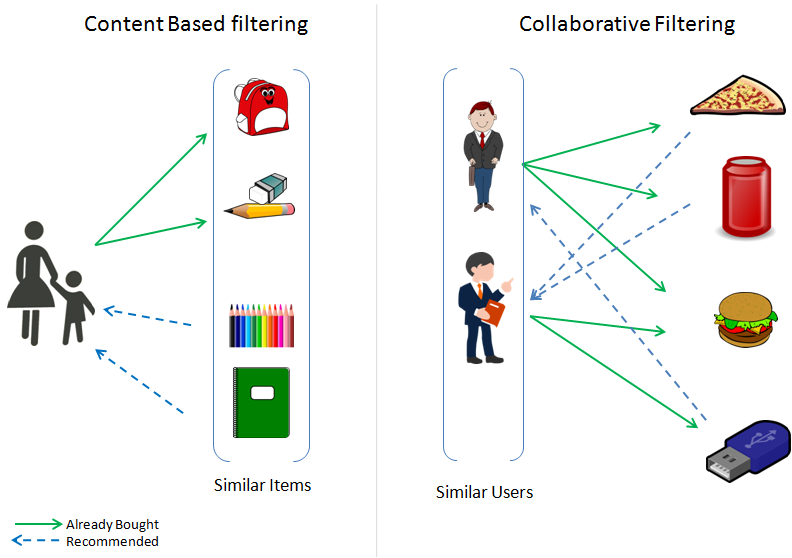

In [47]:
from IPython.display import Image
Image(filename='../Chapter 5 Figures/Recommender_System.png', width=600)

Let's consider a movie rating dataset for 6 movies and 7 users as shown in below table.

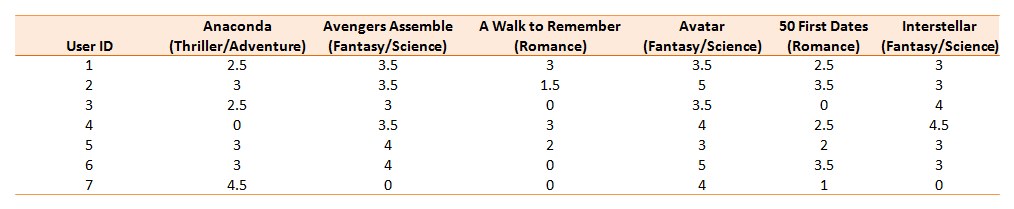

In [48]:
from IPython.display import Image
Image(filename='../Chapter 5 Figures/Movie_Rating.png', width=900)

In [49]:
import numpy as np
import pandas as pd

df = pd.read_csv('Data/movie_rating.csv')

n_users = df.userID.unique().shape[0]
n_items = df.itemID.unique().shape[0]
print '\nNumber of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items)


Number of users = 7 | Number of movies = 6


In [50]:
# Create user-item matrices
df_matrix = np.zeros((n_users, n_items))
for line in df.itertuples():
    df_matrix[line[1]-1, line[2]-1] = line[3]  
    
from sklearn.metrics.pairwise import pairwise_distances

user_similarity = pairwise_distances(df_matrix, metric='euclidean')
item_similarity = pairwise_distances(df_matrix.T, metric='euclidean')

In [52]:
# Top 3 similar users for user id 7
print "Similar users for user id 7: \n", pd.DataFrame(user_similarity).loc[6,pd.DataFrame(user_similarity).loc[6,:] > 0].sort_values(ascending=False)[0:3]

# Top 3 similar items for item id 6
print "Similar items for item id 6: \n", pd.DataFrame(item_similarity).loc[5,pd.DataFrame(item_similarity).loc[5,:] > 0].sort_values(ascending=False)[0:3]

Similar users for user id 7: 
3    8.000000
0    6.062178
5    5.873670
Name: 6, dtype: float64
Similar items for item id 6: 
0    6.557439
2    5.522681
3    4.974937
Name: 5, dtype: float64


### Item based similarity

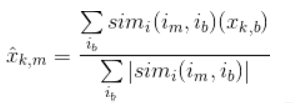

In [9]:
from IPython.display import Image
Image(filename='../Chapter 5 Figures/Item_Similarity_Formula.png', width=300)

In [53]:
# Function for item based rating prediction
def item_based_prediction(rating_matrix, similarity_matrix):
    return rating_matrix.dot(similarity_matrix) / np.array([np.abs(similarity_matrix).sum(axis=1)])     

item_based_prediction = item_based_prediction(df_matrix, item_similarity)

### Memory based collaborative filtering (user based similarity)

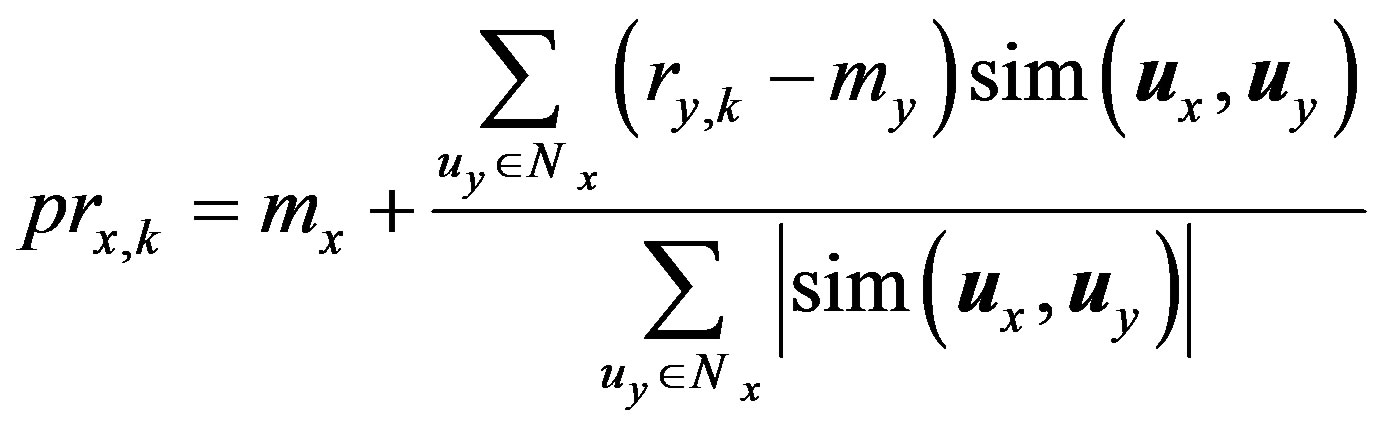

In [54]:
from IPython.display import Image
Image(filename='../Chapter 5 Figures/User_Similarity_Formula.png', width=300)

In [55]:
# Function for user based rating prediction
def user_based_prediction(rating_matrix, similarity_matrix):
    mean_user_rating = rating_matrix.mean(axis=1)
    ratings_diff = (rating_matrix - mean_user_rating[:, np.newaxis]) 
    return mean_user_rating[:, np.newaxis] + similarity_matrix.dot(ratings_diff) / np.array([np.abs(similarity_matrix).sum(axis=1)]).T

user_based_prediction = user_based_prediction(df_matrix, user_similarity)

In [56]:
# Calculate the RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, actual):
    prediction = prediction[actual.nonzero()].flatten() 
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, actual))

print 'User-based CF RMSE: ' + str(rmse(user_based_prediction, df_matrix))
print 'Item-based CF RMSE: ' + str(rmse(item_based_prediction, df_matrix))    

User-based CF RMSE: 1.0705767849
Item-based CF RMSE: 1.37392288971


In [57]:
y_user_based = pd.DataFrame(user_based_prediction)

# Predictions for movies that the user 6 hasn't rated yet
predictions = y_user_based.loc[6,pd.DataFrame(df_matrix).loc[6,:] == 0] 
top = predictions.sort_values(ascending=False).head(n=1)
recommendations = pd.DataFrame(data=top)
recommendations.columns = ['Predicted Rating']
print recommendations

   Predicted Rating
1          2.282415


In [58]:
y_item_based = pd.DataFrame(item_based_prediction)

# Predictions for movies that the user 6 hasn't rated yet
predictions = y_item_based.loc[6,pd.DataFrame(df_matrix).loc[6,:] == 0] 
top = predictions.sort_values(ascending=False).head(n=1)
recommendations = pd.DataFrame(data=top)
recommendations.columns = ['Predicted Rating']
print recommendations

   Predicted Rating
5          2.262497


### Model based collaborative filtering (user based similarity)

In [46]:
# calculate sparsity level
sparsity=round(1.0-len(df)/float(n_users*n_items),3)
print 'The sparsity level of is ' +  str(sparsity*100) + '%'

import scipy.sparse as sp
from scipy.sparse.linalg import svds

# Get SVD components from train matrix. Choose k.
u, s, vt = svds(df_matrix, k = 5)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print 'User-based CF MSE: ' + str(rmse(X_pred, df_matrix))

The sparsity level of is 0.0%
User-based CF MSE: 0.015742898995


In our case since the data set is small sparsity level is 0%. I recommend you to try this method on the MovieLens 100k dataset which you can download from https://grouplens.org/datasets/movielens/100k/